In [2]:
import numpy as np
import pandas as pd

gtzan_dataset = pd.read_csv('gtzan_dataset.csv')
print(gtzan_dataset.shape)

gtzan_dataset.head()

(128, 5)


,Unnamed: 0,filename,label,label_name,sets
0,0,bagpipe,0,music,train
1,1,ballad,0,music,train
2,2,bartok,0,music,train
3,3,beat,0,music,train
4,4,beatles,0,music,train


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
from librosa.feature import melspectrogram
from librosa.core import amplitude_to_db

import multiprocessing
from joblib import Parallel, delayed
from librosa.feature import delta
from keras.models import Sequential	
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
import matplotlib.pyplot as plt

def generateEvaluationGraph(history,i):
    # Loss curves
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))    
    f.suptitle('Fold: '+str(i),fontsize=18)
    ax1.plot(history.history['loss'],'r',linewidth=3.0)
    ax1.plot(history.history['val_loss'],'b',linewidth=3.0)
    ax1.legend(['Training set', 'Validation set'],fontsize=16)
    ax1.set_xlabel('Epochs ',fontsize=16)
    ax1.set_ylabel('Loss %',fontsize=16)
    ax1.set_title('Loss Curves',fontsize=16)
    # Accuracy Curves
    ax2.plot(history.history['acc'],'r',linewidth=3.0)
    ax2.plot(history.history['val_acc'],'b',linewidth=3.0)
    ax2.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
    ax2.set_xlabel('Epochs ',fontsize=16)
    ax2.set_ylabel('Accuracy',fontsize=16)
    ax2.set_title('Accuracy Curves',fontsize=16)

    return f

def load_gtzan():
    metadata = pd.read_csv(os.path.join(FILES_PATH, 'gtzan_dataset.csv'))

    rows_meta = []
    rows_audio = []

    for key, row in metadata.iterrows():
        filename = row['filename']
        label = row['label']
        label_name = row['label_name']
        dataset = row['sets']
        rows_meta.append(
            pd.DataFrame({
                'filename': filename,
                'label': label, 
                'label_name': label_name,
                'sets': dataset
            }, index=[0])
        )
        audio_path = os.path.join(FILES_PATH, 'dataset', 'dataset', filename)
        audio, sr = librosa.load(audio_path)
        if audio is not None:
            rows_audio.append(audio)
            
    rows_meta = pd.concat(rows_meta, ignore_index=True)
    rows_audio = np.vstack(rows_audio)
    rows_meta[['label']] = rows_meta[['label']].astype(int)

    return rows_meta, rows_audio

def extract_segments(clip, filename, sets, label, label_name, frames):
    FRAMES_PER_SEGMENT = frames - 1  # 41 frames ~= 950 ms
    WINDOW_SIZE = 512 * FRAMES_PER_SEGMENT  # 23 ms per frame
    STEP_SIZE = 512 * FRAMES_PER_SEGMENT // 2  # 512 * 20 = 10240
    BANDS = 60

    s = 0
    segments = []

    normalization_factor = 1 / np.max(np.abs(clip))
    clip = clip * normalization_factor

    while len(clip[s * STEP_SIZE:s * STEP_SIZE + WINDOW_SIZE]) == WINDOW_SIZE:
        signal = clip[s * STEP_SIZE:s * STEP_SIZE + WINDOW_SIZE]
        melspec = melspectrogram(signal, sr=22050, n_fft=1024, hop_length=512, n_mels=BANDS)
        logspec = amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        logspec = pd.DataFrame(
            data=logspec, dtype='float32', index=[0],
            columns=list('logspec_b{}_f{}'.format(i % BANDS, i // BANDS) for i in range(np.shape(logspec)[1]))
        )
        if np.mean(logspec.values) > -70.0:
            segment_meta = pd.DataFrame({
                'filename': filename,
                'sets': sets,
                'label': label,
                'label_name': label_name,
                's_begin': s * STEP_SIZE,
                's_end': s * STEP_SIZE + WINDOW_SIZE
            }, index=[0])
            segments.append(pd.concat((segment_meta, logspec), axis=1))
                
        s = s + 1
        
    segments = pd.concat(segments, ignore_index=True)
    return segments
  
def extract_features(meta, audio, frames=41):
    np.random.seed(20170927)
    batch_size = 100
    segments = []

    for b in range(len(audio) // batch_size + 1):
        start = b * batch_size
        end = (b + 1) * batch_size
        if end > len(audio):
            end = len(audio)
        segments.extend(Parallel(n_jobs=CPU_COUNT)(delayed(extract_segments)(
            audio[i, :],
            meta.loc[i, 'filename'],
            meta.loc[i, 'sets'],
            meta.loc[i, 'label'],
            meta.loc[i, 'label_name'],
            frames) for i in range(start, end)))
        segments = [pd.concat(segments, ignore_index=True)]
    
    return segments[0]

def generate_deltas(X):
    new_dim = np.zeros(tuple(np.shape(X)))
    X = np.concatenate((X, new_dim), axis=3)
    del new_dim

    for i in range(len(X)):
        X[i, :, :, 1] = delta(X[i, :, :, 0])
    return X
  
def to_one_hot(labels, class_count):
    one_hot_enc = np.zeros((len(labels), class_count))
    for r in range(len(labels)):
        one_hot_enc[r, labels[r]] = 1
    return one_hot_enc

def create_CNN():
    model = Sequential()

    # layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 41, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # layer 2
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # full connected
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return(model)

#if __name__==__main__:
FILES_PATH=os.getcwd()
gtzan_meta, gtzan_audio = load_gtzan()
CPU_COUNT = multiprocessing.cpu_count()
gtzan_features = extract_features(gtzan_meta, gtzan_audio)

shape = (-1, 60, 41, 1)
start_col = 'logspec_b0_f0'
end_col = gtzan_features.columns[-1]
class_count = len(pd.unique(gtzan_features['label']))
train = gtzan_features[(gtzan_features['sets'] == 'train')]
test = gtzan_features[(gtzan_features['sets'] == 'test')]

X_train = train.loc[:, start_col:end_col].values
y_train = to_one_hot(train['label'].values, class_count)

X_test = test.loc[:, start_col:end_col].values
y_test = to_one_hot(test['label'].values, class_count)

X_mean = np.mean(X_train)
X_std = np.std(X_train)

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = np.reshape(X_train, shape, order='F')
X_test = np.reshape(X_test, shape, order='F')

X_train = generate_deltas(X_train)
X_test = generate_deltas(X_test)

c:\users\rc\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [13]:
gtzan_features.head(10)

,filename,sets,label,label_name,s_begin,s_end,logspec_b0_f0,logspec_b1_f0,logspec_b2_f0,logspec_b3_f0,...,logspec_b50_f40,logspec_b51_f40,logspec_b52_f40,logspec_b53_f40,logspec_b54_f40,logspec_b55_f40,logspec_b56_f40,logspec_b57_f40,logspec_b58_f40,logspec_b59_f40
0,bagpipe.wav,train,0,music,0,20480,-16.554281,-18.910244,-18.798805,-25.235842,...,-53.059746,-45.487907,-57.065350,-58.015015,-60.723236,-60.723236,-58.859566,-60.723236,-60.723236,-60.723236
1,bagpipe.wav,train,0,music,10240,30720,-5.471920,-7.940930,-19.434341,-21.961439,...,-33.289192,-40.435539,-61.323380,-39.885048,-56.448921,-51.397743,-51.073975,-59.645878,-57.014702,-67.875984
2,bagpipe.wav,train,0,music,20480,40960,-11.418022,-9.673354,-14.572149,-32.978149,...,-49.816700,-36.416832,-67.875984,-43.877296,-57.130943,-51.321930,-53.359970,-51.025795,-56.214890,-64.001755
3,bagpipe.wav,train,0,music,30720,51200,-10.584950,-20.315220,-33.074169,-34.420921,...,-23.863682,-32.695278,-46.656235,-36.567463,-46.241909,-49.860020,-52.660965,-56.031319,-53.549992,-43.930031
4,bagpipe.wav,train,0,music,40960,61440,-8.843783,-13.872174,-40.255951,-57.132057,...,-21.504959,-30.728521,-35.753113,-30.730141,-30.266022,-37.229218,-36.733746,-41.561493,-40.755486,-50.393635
5,bagpipe.wav,train,0,music,51200,71680,-12.195520,-11.604467,-27.181332,-25.604019,...,-36.662930,-39.218304,-27.979155,-33.465042,-35.312965,-40.943321,-50.457241,-49.015392,-44.244045,-47.207142
6,bagpipe.wav,train,0,music,61440,81920,-7.799634,-13.271852,-18.551929,-12.477246,...,-1.617423,-30.372833,-42.982220,-39.655209,-44.934383,-38.577679,-41.128849,-36.912472,-40.913349,-44.934383
7,bagpipe.wav,train,0,music,71680,92160,-6.500518,-10.158668,-34.896778,-44.934383,...,-21.313026,-24.860308,-36.247566,-31.743937,-43.212109,-44.934383,-41.283016,-42.121498,-44.934383,-38.573200
8,bagpipe.wav,train,0,music,81920,102400,-10.180369,-16.980005,-33.682297,-38.336342,...,-25.402910,-38.446770,-34.977619,-25.701611,-41.931705,-34.524044,-34.474236,-41.931705,-41.931705,-41.931705
9,bagpipe.wav,train,0,music,92160,112640,-9.414950,-14.704429,-20.391953,-32.453896,...,-10.030226,-20.072191,-28.369219,-33.199913,-27.095699,-41.931705,-41.931705,-41.931705,-41.931705,-41.931705


In [14]:
X_train.shape

(6419, 60, 41, 2)

Train on 6419 samples, validate on 1637 samples
Epoch 1/100
6419/6419 [==============================] - 3s 428us/step - loss: 0.8534 - acc: 0.5678 - val_loss: 0.6509 - val_acc: 0.7935
Epoch 2/100
6419/6419 [==============================] - 1s 86us/step - loss: 0.5894 - acc: 0.7431 - val_loss: 0.5768 - val_acc: 0.7648
Epoch 3/100
6419/6419 [==============================] - 1s 87us/step - loss: 0.4110 - acc: 0.8414 - val_loss: 0.3143 - val_acc: 0.9114
Epoch 4/100
6419/6419 [==============================] - 1s 84us/step - loss: 0.2547 - acc: 0.8973 - val_loss: 0.1963 - val_acc: 0.9365
Epoch 5/100
6419/6419 [==============================] - 1s 84us/step - loss: 0.1863 - acc: 0.9285 - val_loss: 0.1348 - val_acc: 0.9652
Epoch 6/100
6419/6419 [==============================] - 1s 89us/step - loss: 0.1462 - acc: 0.9445 - val_loss: 0.1211 - val_acc: 0.9652
Epoch 7/100
6419/6419 [==============================] - 1s 84us/step - loss: 0.1275 - acc: 0.9525 - val_loss: 0.1139 - val_acc: 0.9652

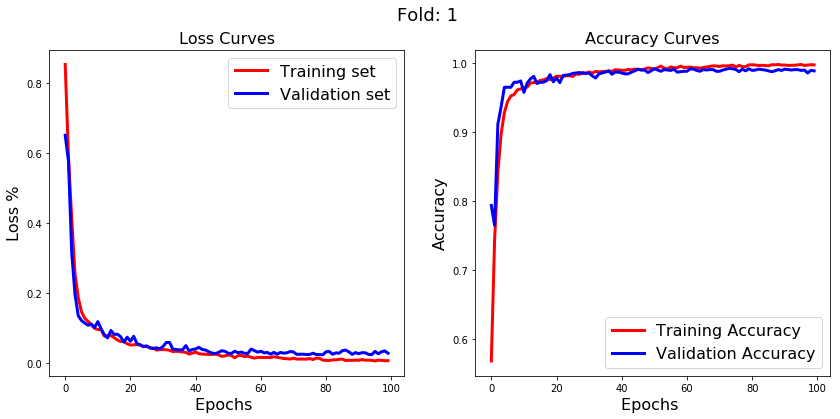

In [5]:
### start session
session_config = K.tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
#please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90

sess = K.tf.Session(config=session_config)
K.set_session(sess)

model=create_CNN()
history = model.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

fig=generateEvaluationGraph(history,1)


In [6]:
print('true\tpredict\tcorrect')
for i,x in enumerate(X_test):
#    print(x.shape)
    y_pred = np.argmax(model.predict(x.reshape(1, 60, 41, 2)))
    y_true = np.argmax(y_test[i])
    if y_true==y_pred:
        print('%d\t%d\tY'%(y_true,y_pred))
    else:
        print('%d\t%d\tN'%(y_true,y_pred))


true	predict	correct
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	1	N
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	1	N
0	0	Y
0	1	N
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0	0	Y
0

1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	0	N
1	1	Y
1	1	Y
1	0	N
1	0	N
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	Y
1	1	